In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from PIL import Image
import cv2

In [2]:
df = pd.read_pickle("data/df_reduced.pkl")

In [3]:
def get_distributions(df:pd.DataFrame, col:str):
    dc = df[col]
    dc.plot.hist(bins=90)
    plt.show()
    plt.close()
    print(dc.describe())
    return dc

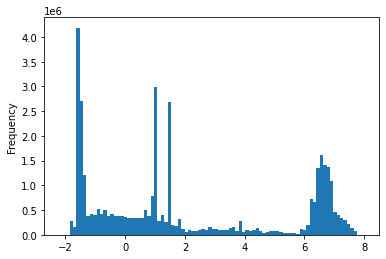

count    3.779235e+07
mean     2.037326e+00
std      3.237981e+00
min     -2.202500e+00
25%     -1.038500e+00
50%      1.033500e+00
75%      6.281500e+00
max      7.987500e+00
Name: cartesianZ, dtype: float64


In [4]:
dc  = get_distributions(df, "cartesianZ")

In [5]:
dc_hist = np.histogram(dc.values, bins=80)

In [6]:
hist_weights = dc_hist[0] / dc_hist[0].sum()

In [7]:
hist_centers = dc_hist[1]

In [8]:
sampled_data = np.random.choice(hist_centers[1:], size=10000, p = hist_weights)

In [9]:
gmm = GaussianMixture(5)
gmm = gmm.fit(sampled_data.reshape(-1,1))

In [10]:
floor_id = np.argmin(gmm.means_)
ceil_id = np.argmax(gmm.means_)

floor_cutoff = (gmm.means_[floor_id] + np.sqrt(gmm.covariances_[floor_id])*2).reshape(-1)[0]
ceil_cutoff = (gmm.means_[ceil_id] - np.sqrt(gmm.covariances_[ceil_id])*2).reshape(-1)[0]

In [11]:
floor_cutoff

-1.3098270321267207

In [12]:
ceil_cutoff

6.581036176571336

In [13]:
df = df[df.cartesianZ > floor_cutoff]
df = df[df.cartesianZ < ceil_cutoff-2]


In [14]:
df_plot = df[["cartesianX", "cartesianY", "intensity"]]

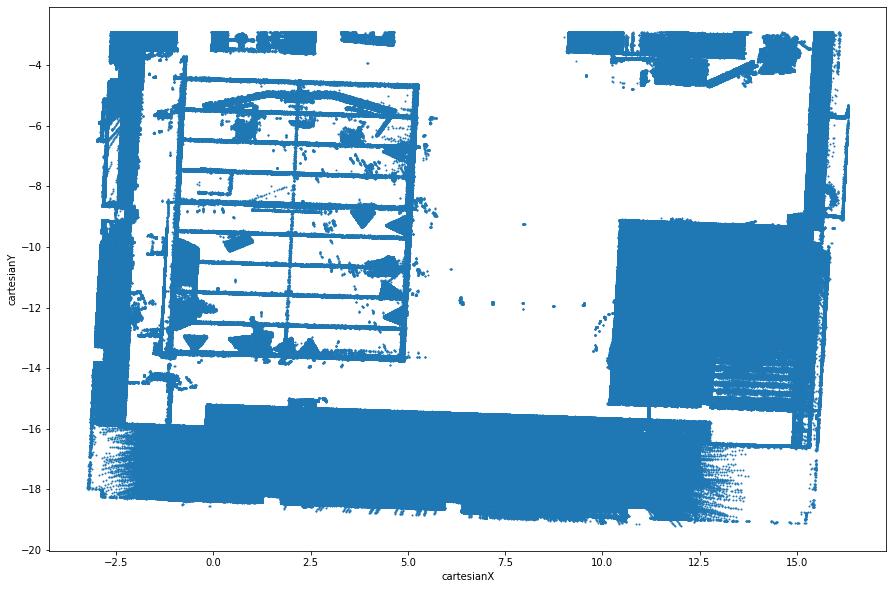

In [15]:
df_plot.plot.scatter("cartesianX", "cartesianY", s = 1, figsize=(15,10))
plt.show()

In [16]:
# Quick experiment to pixel

In [77]:
coords = df[["cartesianX", "cartesianY"]].copy()

minx = coords.cartesianX.min()
miny = coords.cartesianY.min()

coords.cartesianX -= minx
coords.cartesianY -= miny

coords.cartesianX *= 1000
coords.cartesianX = coords.cartesianX.round().astype(np.int32)

coords.cartesianY *= 1000
coords.cartesianY = coords.cartesianY.round().astype(np.int32)

maxx = coords.cartesianX.max()
maxy = coords.cartesianY.max()

In [78]:
matrix_bw_original = np.zeros([maxx+1, maxy+1], np.uint8)
matrix_bw_original[coords.cartesianX.values, coords.cartesianY.values] = 255

# Morphology
kernel = np.ones((5,5),np.uint8)
img = cv2.dilate(matrix_bw_original,kernel,iterations = 1)

# Open
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# Close
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)


# Whap up with dilation to make sure connected
kernel = np.ones((4,4),np.uint8)
img = cv2.dilate(img,kernel,iterations = 1)



# Dilate to connect
img = Image.fromarray(matrix_bw_original, "L")

In [79]:
(width, height) = (img.width // 4, img.height // 4)
img = img.resize((width, height))

img.save('data/image.png')
img.show()

In [ ]:
def post_morph_image(df: pd.DataFrame) -> Tuple[np.ndarray, Any]:
    """
    returns ndarray representation and the scaled image
    """